In [238]:
import numpy as np       # the NumPy library for fast matrix and vector data types and math operations
import matplotlib.pyplot as plt   # functions for plotting, loaded under a convenient name alias 'plt'
from pylab import plot, show, xlabel, ylabel, legend, semilogy,semilogx, grid, xlim, ylim, title,savefig, minorticks_on, figtext
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 9),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
import csv
import pandas as pd
from astropy import modeling
from scipy import optimize
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from scipy.integrate import quad
import datetime
from datetime import timedelta
from datetime import datetime

In [246]:
def gaussian(x, amplitude, mean, stddev,offset): #make a funciton that returns a gaussian
    return amplitude * np.exp(-((x - mean)/ stddev)**2/ 2)+offset

def integrand(x, mean, stddev,offset):
    return (np.exp(-((x - mean)/ stddev)**2)+offset)

Import Thomson data

In [247]:
shotnr=[28925,28928,28935,28939,28943,28947,28950]
def TS(expnum):
    filename=('Thomson_2021-06-10_#' + str(shotnr[expnum-1]) + '.txt')
    df = pd.read_csv(filename, delimiter = "\t", skiprows=5, warn_bad_lines=True, error_bad_lines=False) #remove lines that do not have 5 columns 
    data_columns=df.columns.values
    num_df = (df.drop(data_columns, axis=1).join(df[data_columns].apply(pd.to_numeric, errors='coerce'))) #remove the lines that are not fully numerical
    num_df = num_df[num_df[data_columns].notnull().all(axis=1)] #remove the lines that are not fully numerical
    num_df.index=list(range(0, len(num_df))) #sets the indec to start at 0 and increase by 1, row number

    # There are 3 Thomson measurements per exp so we need to see which times correspond to thebegining and end of each exp. 
    difference = num_df.diff(axis=0) #difference between two consecutive rows
    t12=num_df[difference.iloc[:,0]<0].index.values #the 1st column is the position which per measurement always increases, so if the diff is negative it means we have a new measurement 
    T1=num_df.iloc[0:t12[0]]
    T2=num_df.iloc[t12[0]:t12[1]]
    T3=num_df.iloc[t12[1]:len(num_df)]

    popt, pcov = optimize.curve_fit(gaussian, T3.iloc[:,0], T3.iloc[:,2],[3,3,1,0],bounds=((0, -np.inf,0, -np.inf),(np.inf,np.inf,np.inf, np.inf))) # Optimize for temperature, popt is: [amplitude, mean, stddev,offset]
    popt_n, pcov_n = optimize.curve_fit(gaussian, T3.iloc[:,0], (T3.iloc[:,1]*1e-19),[2,3,6,3]) # Optimize for temperature, popt is: [amplitude, mean, stddev,offset]
    #qprof=gaussian(x, *popt)**(1.5)*gaussian(x, *popt_n)
    return T3,popt,popt_n

T3,popt,popt_n=TS(3)


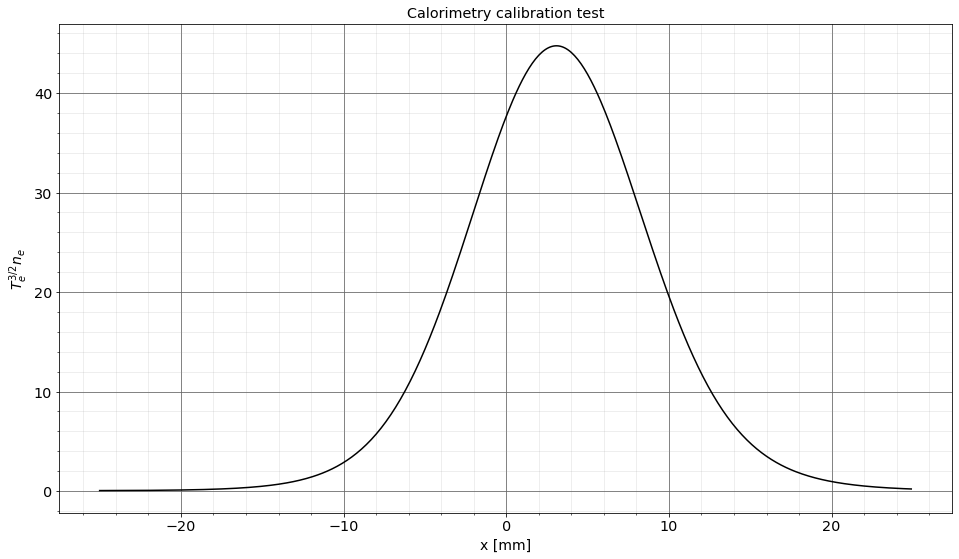

In [248]:
T3,popt,popt_n,qprof=TS(3)
gaussian(x, *popt)
iets=1
plot(x,qprof, 'k-')
xlabel('x [mm]', fontsize=14)
ylabel('$T_e^{3/2}n_e$',fontsize=14)
grid(b=True, which='major', color='#666666')
minorticks_on()
grid(b=True, which='minor', color='#999999', alpha=0.2)
title('Calorimetry calibration test')
show()


Plot the first TS data

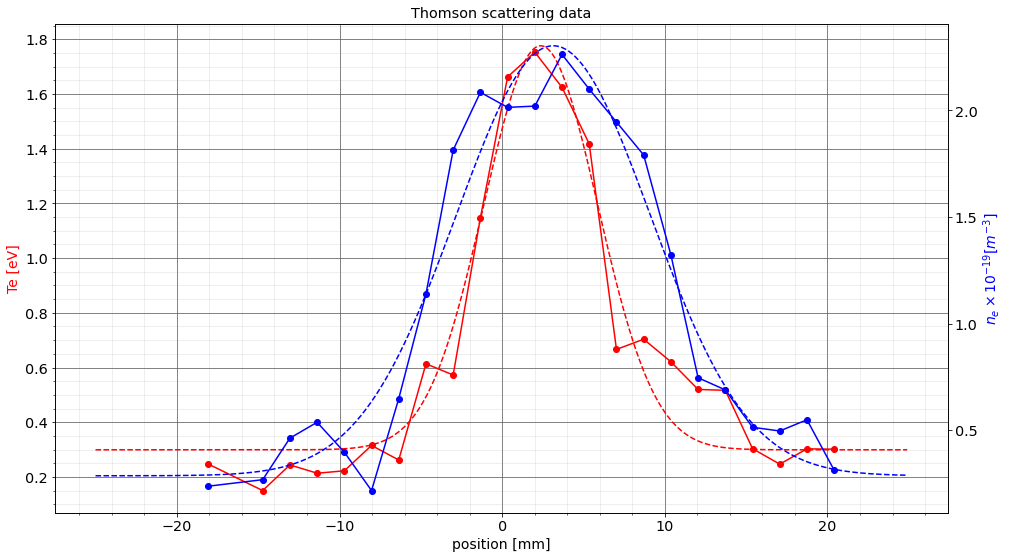

array([1.47668963, 2.37102546, 3.50009043, 0.29930233])

In [341]:
x=np.arange(-25,25,0.1)
T3,popt,popt_n,popt_q=TS(1)
fig,ax = plt.subplots()
ax.plot(T3.iloc[:,0],T3.iloc[:,2],'-or')
ax.plot(x, gaussian(x, *popt),'--r')
xlabel('position [mm]', fontsize=14)
ylabel('Te [eV]', color="red",fontsize=14)

grid(b=True, which='major', color='#666666')
minorticks_on()
grid(b=True, which='minor', color='#999999', alpha=0.2)

ax2=ax.twinx()
ax2.plot(T3.iloc[:,0],T3.iloc[:,1]*1e-19,'-ob')
ax2.set_ylabel(r'$n_e \times 10^{-19} [ m^{-3}]$', color="blue",fontsize=14)
ax2.plot(x, gaussian(x, *popt_n),'--b')
title('Thomson scattering data')
#savefig('TS_first.png', dpi=1000)
show()
popt

Calometry calibration

In [250]:
cp=4200 #J
E=97320 #J/kg/K

data=pd.read_csv("temp.csv", delimiter='|', skiprows=1)   #Import calorimetry calibration data
data["Date/Time"] = [datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f') for x in data["Date/Time"]] # converts the time strings to readable datetime
time_int=data["Date/Time"]-data["Date/Time"][0]
time_int2= [time_int.iloc[ii].total_seconds() for ii in range(len(time_int))] #convert time to seconds
data = data.assign(t=time_int2) # assign the interval found in seconds as a column
data.Value=data.Value-data.Value.iloc[0:37].mean()
Tint=np.trapz(data.Value,data.t) #integrated delta temperature
mflow=E/(Tint*cp) #[kg/s]


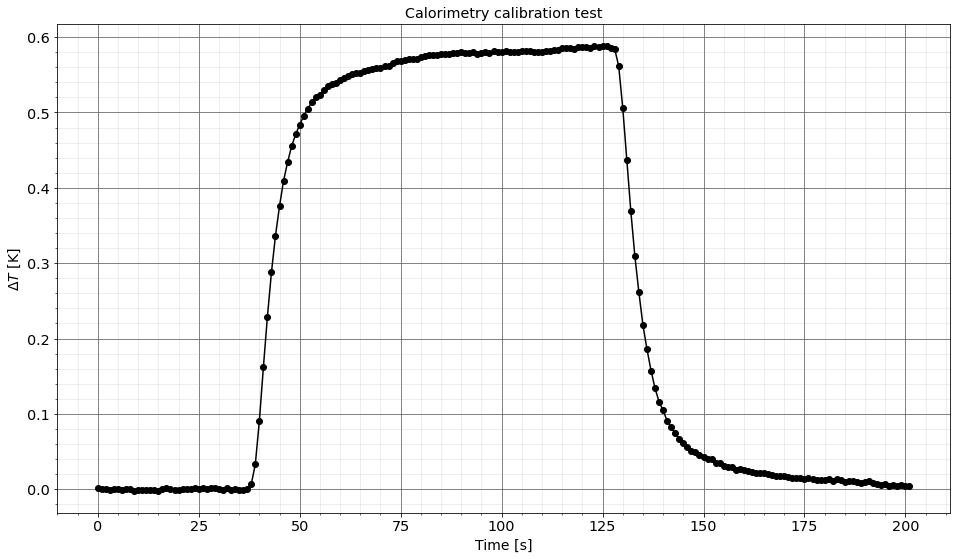

In [251]:
plot(data.t,data.Value, 'ko-')
xlabel('Time [s]', fontsize=14)
ylabel('$\Delta T$ [K]',fontsize=14)
grid(b=True, which='major', color='#666666')
minorticks_on()
grid(b=True, which='minor', color='#999999', alpha=0.2)
title('Calorimetry calibration test')
show()

In [252]:
datacal=pd.read_csv("calorimetry.csv", delimiter='|', skiprows=1)   #Import the experimental data
datacal["Date/Time"] = [datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f') for x in datacal["Date/Time"]] # converts the time strings to readable datetime
tstartcal=["2021-06-10 11:21","2021-06-10 11:44","2021-06-10 13:47","2021-06-10 14:12","2021-06-10 14:38","2021-06-10 14:53","2021-06-10 15:07"]
tstartcal= [datetime.strptime(x,'%Y-%m-%d %H:%M') for x in tstartcal] # converts the time strings to readable datetime
tendcal=[tstartcal[x]+timedelta(seconds=20*60) for x in range(len(tstartcal))] # sets the end of the experiments 20 minutes after the start

def calo(expnum):
    ind1=datacal[datacal["Date/Time"]>tstartcal[expnum-1]].index[expnum-1] #index start time
    ind2=datacal[datacal["Date/Time"]<tendcal[expnum-1]].index[-1] #index end time
    tint=datacal["Date/Time"].iloc[ind1:ind2] # Indexes of the complete experiment
    offset=datacal.Value.iloc[ind1-100:ind1].mean() # Takes the average of the 100 sec before the experiment as a base value 

    #Set expi to the values beloning to this experiment
    expi = pd.DataFrame(columns = ["time", "temp"])
    expi=expi.assign(time=datacal["Date/Time"].iloc[ind1:ind2])
    expi=expi.assign(temp=datacal.Value.iloc[ind1:ind2]-offset) 
    time_int=expi.time-expi.time.iloc[0]
    time_int2= [time_int.iloc[ii].total_seconds() for ii in range(len(time_int))] #convert time to seconds
    expi = expi.assign(t=time_int2) # assign the interval found in seconds as a column
    Tint=np.trapz(expi.temp,expi.t)
    E=mflow*(Tint*cp) #[J]
    P=E/420  # [W] divided by 7 min(the length of the experiment)
    return expi, P

Plot calorimeter data experiment 1

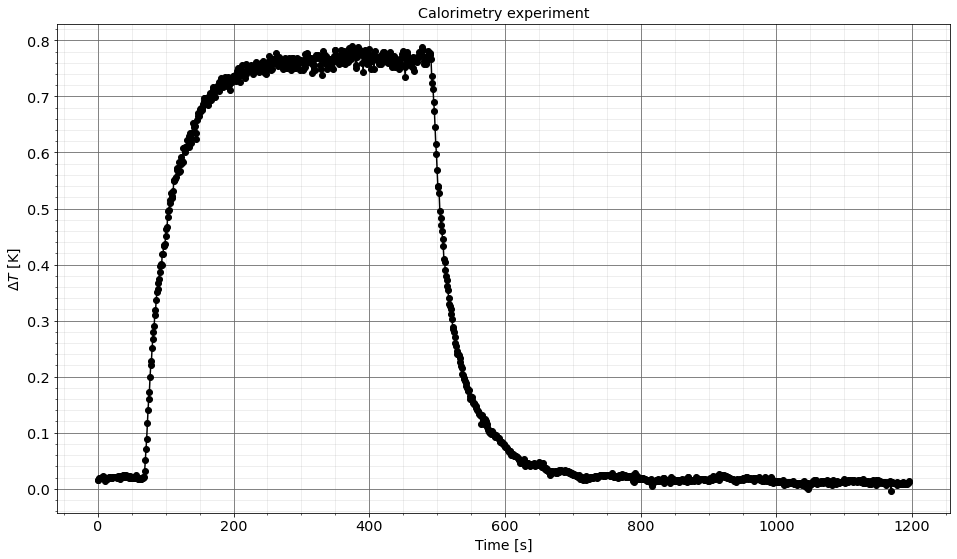

In [253]:
plot(calo(3)[0].t,calo(3)[0].temp, 'ko-')
xlabel('Time [s]', fontsize=14)
ylabel('$\Delta T$ [K]',fontsize=14)
grid(b=True, which='major', color='#666666')
minorticks_on()
grid(b=True, which='minor', color='#999999', alpha=0.2)
title('Calorimetry experiment')
show()


In [344]:
def q(expnum): # [x]=mm, [q]=kW
    T3,popt,popt_n, popt_q=TS(expnum)
    
    x0_q = (popt[1]+popt_n[1])/2
    sig_q = np.sqrt((2*popt[2]**2*popt_n[2]**2)/(2*popt[2]**2+3*popt_n[2]**2))
    
    I = quad(integrand, -20, 25, (x0_q, sig_q, 0) ) #assume offset is zero, there is no heat flux on the edges
    expi, P=calo(expnum)
    A=P/I[0]
    
    q=gaussian(x, A,x0_q, sig_q, 0)
    return q

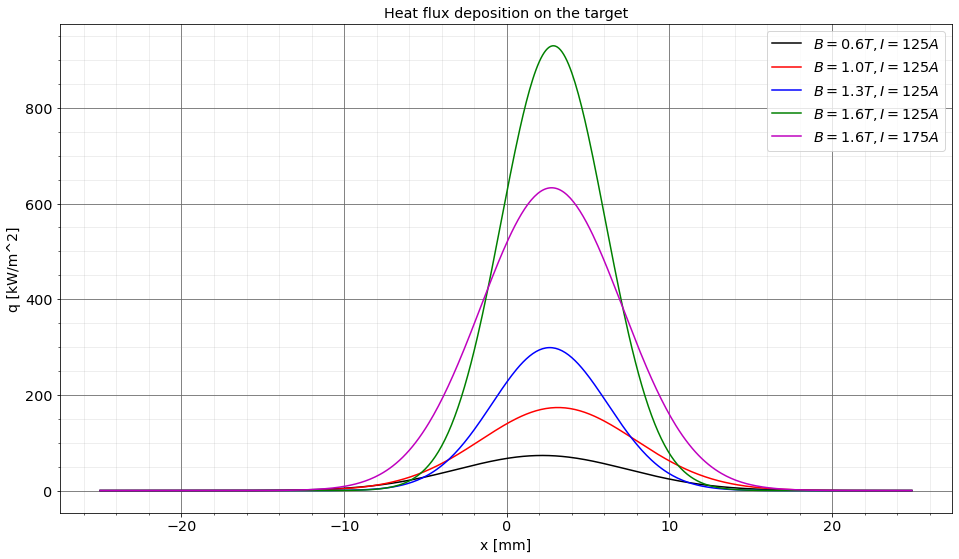

In [343]:
plot(x, q(2), 'k-',label='$B=0.6T,I=125A$')
plot(x, q(3), 'r-',label='$B=1.0T,I=125A$')
plot(x, q(4), 'b-',label='$B=1.3T,I=125A$')
plot(x, q(5), 'g-',label='$B=1.6T,I=125A$')
plot(x, q(6), 'm-',label='$B=1.6T,I=175A$')
#plot(x, q(7), 'y-',label='$B=1.6T,I=200A$')

xlabel('x [mm]', fontsize=14)
ylabel('q [kW/m^2]',fontsize=14)
grid(b=True, which='major', color='#666666')
minorticks_on()
grid(b=True, which='minor', color='#999999', alpha=0.2)
title('Heat flux deposition on the target')
legend()
#savefig('q.png', dpi=1000)
show()


In [ ]:
np.max(q(6))

Pyrometer data

In [263]:
dataPy=pd.read_excel("Pyrometer_data_2021_06_09.xlsx")   #Import the experimental data
dataPy.time = [datetime.strptime(x,'%H:%M:%S.%f') for x in dataPy.time] # converts the time strings to readable datetime
t_diff= [(dataPy.time.diff()).iloc[x].seconds for x in range(len(dataPy))]; # determine the difference between two lines
tstartPy=dataPy[(np.array(t_diff)>120)] #when the difference is larger than 2min (120sec) the expriment has ended 
tendPy=dataPy.iloc[tstartPy.index-1]
tendPy=pd.concat([tendPy,(dataPy.iloc[len(dataPy)-1:len(dataPy)])])


In [353]:
IRnum=[0,7,13,16,20,21] #There is no Pyrometer data for the first two experiments
def IR(expnum):
    i=IRnum[expnum-1]
    dfIR=pd.read_csv("IR"+ str(i+3)+".txt", delimiter = "\t")   #Import the experimental data
    dfIR=dfIR.rename(columns={'(time)': 'time', "1 Mean  (°C)":'temp' })
    dfIR.time = [datetime.strptime(x,'%H:%M:%S.%f') for x in dfIR.time] # converts the time strings to readable datetime
    timeIR=dfIR.time-dfIR.time[0]
    timeIR2= [timeIR.iloc[ii].total_seconds() for ii in range(len(timeIR))] #convert time to seconds
    dfIR = dfIR.assign(t=timeIR2)
    return dfIR
IR(2)

,time,temp,t
0,1900-01-01 13:41:18.720,37.99,0.000
1,1900-01-01 13:41:18.739,31.97,0.019
2,1900-01-01 13:41:18.760,37.32,0.040
3,1900-01-01 13:41:18.779,24.80,0.059
4,1900-01-01 13:41:18.800,26.42,0.080
...,...,...,...
1479,1900-01-01 13:41:48.319,370.93,29.599
1480,1900-01-01 13:41:48.339,371.15,29.619
1481,1900-01-01 13:41:48.360,370.32,29.640
1482,1900-01-01 13:41:48.379,369.85,29.659


In [352]:
plot(IR(2).t,IR(2).temp, 'k*-' ,label='$B=0.6T,I=125A$')
plot(IR(3).t,IR(3).temp, 'k*-' ,label='$B=1.0T,I=125A$')
plot(IR(4).t,IR(4).temp, 'r*-' ,label='$B=1.3T,I=125A$')
plot(IR(5).t,IR(5).temp, 'b*-' ,label='$B=1.3T,I=175A$')
plot(IR(6).t,IR(6).temp, 'g*-' ,label='$B=1.6T,I=200A$')

legend()
xlabel('$time$ $[s]$') 
ylabel('$T$ $[\degree C]$')
ax.yaxis.label.set_color('black')
grid(b=True, which='major', color='#666666')
minorticks_on()
grid(b=True, which='minor', color='#999999', alpha=0.2)
title('IR')
#savefig('Ga_wetted_pyroandIRemissivity023.png', dpi=1000)
show()

FileNotFoundError: [Errno 2] No such file or directory: 'IR3.txt'

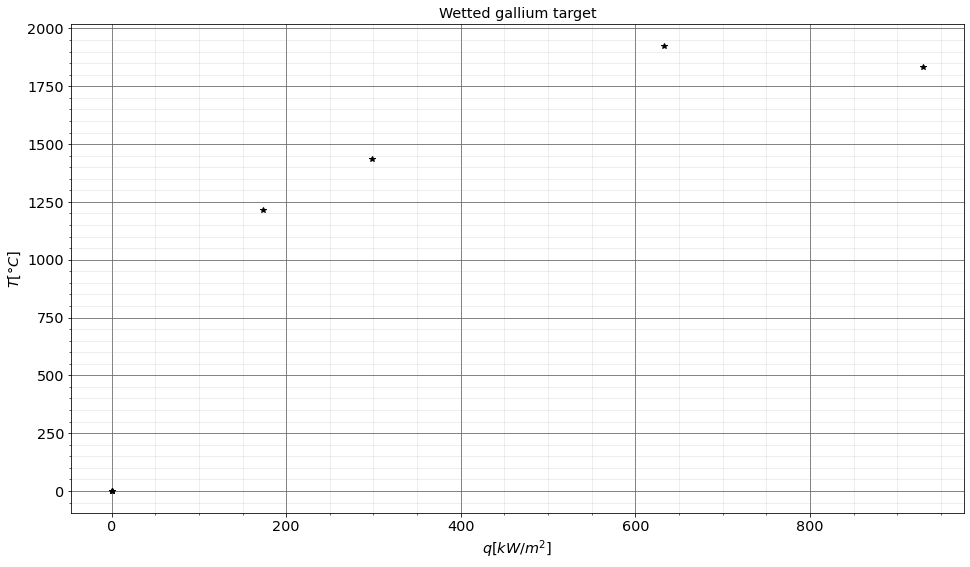

In [351]:
qmax = np.zeros(7)
Tsat= np.zeros(7)
for i in range(3,7):
    Tsat[i]=np.mean(IR(i).temp[IR(i)[IR(i).t<20].index[-1]:IR(i)[IR(i).t<20.5].index[-1]])# mean temperature between 20s and 20.5s for exp3
    qmax[i]=np.max(q(i))

plot(qmax,Tsat, 'k*')
xlabel('$q [kW/m^2]$')
ylabel('$T[\degree C]$') 

ax.yaxis.label.set_color('black')
grid(b=True, which='major', color='#666666')
minorticks_on()
grid(b=True, which='minor', color='#999999', alpha=0.2)
title('Wetted gallium target')
#savefig('Wetted_Ga_qT.png', dpi=1000)
show()